I'm following the AWS example from this [site](https://docs.aws.amazon.com/sagemaker/latest/dg/lightgbm.html) and this [notebook](https://github.com/aws/amazon-sagemaker-examples/blob/main/introduction_to_amazon_algorithms/lightgbm_catboost_tabular/Amazon_Tabular_Classification_LightGBM_CatBoost.ipynb)

# Instals and Imports

In [1]:
!pip install lightgbm

In [49]:
import boto3
import sagemaker
from sagemaker import image_uris, model_uris, script_uris
from sagemaker import get_execution_role
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base
from datetime import datetime
from sagemaker import hyperparameters
aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()
import joblib
import tarfile
import lightgbm
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# LightGBM Training

In [4]:
train_model_id, train_model_version, train_scope = "lightgbm-classification-model", "*", "training"
training_instance_type = "ml.m5.large"

In [5]:
#Retrieve the image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type
)

# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

In [6]:
# Sample training data is available in this bucket
training_data_bucket = "starbucks-project-ttg"
training_data_prefix = "data"

training_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}/train.csv" 
validation_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}/val.csv" 
output_bucket = "starbucks-project-ttg"
output_prefix = "training_results/lightgbm"
s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

## Training without Tuning

In [7]:
# Retrieve the default hyperparameters for training the model
hyperparameters = sagemaker.hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

hyperparameters['metric'] = 'binary_logloss'
hyperparameters['num_boost_round'] = "500"
print(hyperparameters)

{'num_boost_round': '500', 'early_stopping_rounds': '30', 'metric': 'binary_logloss', 'learning_rate': '0.009', 'num_leaves': '67', 'feature_fraction': '0.74', 'bagging_fraction': '0.53', 'bagging_freq': '5', 'max_depth': '11', 'min_data_in_leaf': '26', 'max_delta_step': '0.0', 'lambda_l1': '0.0', 'lambda_l2': '0.0', 'boosting': 'gbdt', 'min_gain_to_split': '0.0', 'scale_pos_weight': '1.0', 'tree_learner': 'serial', 'feature_fraction_bynode': '1.0', 'is_unbalance': 'False', 'max_bin': '255', 'num_threads': '0', 'verbosity': '1', 'use_dask': 'False'}


In [8]:
time_stamp = datetime.strftime(datetime.now(), '%Y-%m-%d-%H-%M')
training_job_name = name_from_base(f"built-in-algo-{train_model_id}-hptuning-training-{time_stamp}")
training_job_name

'built-in-algo-lightgbm-classification-m-2023-03-29-02-08-09-247'

In [9]:
# Create SageMaker Estimator instance
tabular_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1, # for distributed training, specify an instance_count greater than 1
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location
)

In [10]:
# Launch a SageMaker Training job by passing the S3 path of the training data
tabular_estimator.fit(
    {
        "train": training_dataset_s3_path,
        "validation": validation_dataset_s3_path,
    }, logs=True, job_name=training_job_name
)

INFO:sagemaker:Creating training-job with name: built-in-algo-lightgbm-classification-m-2023-03-29-02-08-09-247


2023-03-29 02:08:16 Starting - Starting the training job...
2023-03-29 02:08:31 Starting - Preparing the instances for training...
2023-03-29 02:09:22 Downloading - Downloading input data...
2023-03-29 02:09:52 Training - Downloading the training image......
2023-03-29 02:10:38 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-29 02:10:42,503 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-29 02:10:42,505 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-29 02:10:42,514 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-29 02:10:42,516 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-03-29 02:10:42,888 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:

## LightGBM Hyperparameter Tuning

In [11]:
tuned_output_prefix = "training_results/lightgbm-tuned"
tuned_s3_output_location = f"s3://{output_bucket}/{tuned_output_prefix}/output"

In [12]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(1e-4, 1, scaling_type="Logarithmic"),
    "num_boost_round": IntegerParameter(50, 1000),
    "early_stopping_rounds": IntegerParameter(2, 30),
    "num_leaves": IntegerParameter(10, 50),
    "feature_fraction": ContinuousParameter(0, 1),
    "bagging_fraction": ContinuousParameter(0, 1),
    "bagging_freq": IntegerParameter(1, 10),
    "max_depth": IntegerParameter(5, 30),
    "min_data_in_leaf": IntegerParameter(5, 50)
}

In [13]:
tune_time_stamp = datetime.strftime(datetime.now(), '%Y-%m-%d-%H-%M')
tuning_job_name = name_from_base(f"built-in-algo-{train_model_id}-hptuning-training-{time_stamp}")
tuning_job_name

'built-in-algo-lightgbm-classification-m-2023-03-29-02-14-39-210'

In [14]:
tuner = HyperparameterTuner(
    estimator = tabular_estimator,
    objective_metric_name = 'binary_logloss',#"multi_logloss",
    hyperparameter_ranges = hyperparameter_ranges,
    metric_definitions = [{"Name": "binary_logloss", "Regex": "binary_logloss: ([0-9\\.]+)"}],
    max_jobs=10,
    max_parallel_jobs=2,
    objective_type="Minimize",
    base_tuning_job_name=training_job_name,
)
# else:
#     print('skipped tuning')
#     # Launch a SageMaker Training job by passing s3 path of the training data
#     tabular_estimator.fit(
#         {"training": training_dataset_s3_path}, logs=True, job_name=training_job_name
#     )

In [15]:
tuner.fit({
        "train": training_dataset_s3_path,
        "validation": validation_dataset_s3_path,
    }, logs=True)

INFO:sagemaker:Creating hyperparameter tuning job with name: built-in-algo-lightg-230329-0216


..........................................................................................................!


In [16]:
best_estimator = tuner.best_estimator()


2023-03-29 02:25:12 Starting - Found matching resource for reuse
2023-03-29 02:25:12 Downloading - Downloading input data
2023-03-29 02:25:12 Training - Training image download completed. Training in progress.
2023-03-29 02:25:12 Uploading - Uploading generated training model
2023-03-29 02:25:12 Completed - Resource retained for reuse


In [19]:
tuner.best_training_job()

'built-in-algo-lightg-230329-0216-010-bc1593b6'

In [17]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': 'binary_logloss',
 'bagging_fraction': '0.6772905568883868',
 'bagging_freq': '4',
 'boosting': '"gbdt"',
 'early_stopping_rounds': '20',
 'feature_fraction': '0.6238013443424262',
 'feature_fraction_bynode': '"1.0"',
 'is_unbalance': '"False"',
 'lambda_l1': '"0.0"',
 'lambda_l2': '"0.0"',
 'learning_rate': '0.30152397356934835',
 'max_bin': '"255"',
 'max_delta_step': '"0.0"',
 'max_depth': '10',
 'metric': '"binary_logloss"',
 'min_data_in_leaf': '6',
 'min_gain_to_split': '"0.0"',
 'num_boost_round': '310',
 'num_leaves': '50',
 'num_threads': '"0"',
 'sagemaker_container_log_level': '20',
 'sagemaker_job_name': '"sagemaker-jumpstart-2023-03-29-02-16-26-243"',
 'sagemaker_program': '"transfer_learning.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://jumpstart-cache-prod-us-east-1/source-directory-tarballs/lightgbm/transfer_learning/classification/v2.1.1/sourcedir.tar.gz"',
 'scale_pos_weight': '"1.0"',
 'tree_learner': '"s

## LightGBM Out of Sample Testing

Now that I trained a model and tuned it, I want to compare the output between the untuned lightgbm model and the tuned lightgbm model.

### Loading Trained Models

In [23]:
!aws s3 cp s3://starbucks-project-ttg/training_results/lightgbm/output/built-in-algo-lightgbm-classification-m-2023-03-29-02-08-09-247/output/model.tar.gz /root/starbucks_offer_response_model/trained_models/lightgbm/untuned_model

download: s3://starbucks-project-ttg/training_results/lightgbm/output/built-in-algo-lightgbm-classification-m-2023-03-29-02-08-09-247/output/model.tar.gz to ../trained_models/lightgbm/untuned_model/model.tar.gz


In [24]:
!aws s3 cp s3://starbucks-project-ttg/training_results/lightgbm/output/built-in-algo-lightg-230329-0216-010-bc1593b6/output/model.tar.gz /root/starbucks_offer_response_model/trained_models/lightgbm/tuned_model

download: s3://starbucks-project-ttg/training_results/lightgbm/output/built-in-algo-lightg-230329-0216-010-bc1593b6/output/model.tar.gz to ../trained_models/lightgbm/tuned_model/model.tar.gz


In [25]:
untuned_tar_file_path = '/root/starbucks_offer_response_model/trained_models/lightgbm/untuned_model/model.tar.gz'

In [26]:
t_un = tarfile.open(untuned_tar_file_path)

In [28]:
t_un.extractall('/root/starbucks_offer_response_model/trained_models/lightgbm/untuned_model')

In [29]:
untuned_model = joblib.load('/root/starbucks_offer_response_model/trained_models/lightgbm/untuned_model/model.pkl')

In [30]:
tuned_tar_file_path = '/root/starbucks_offer_response_model/trained_models/lightgbm/tuned_model/model.tar.gz'

In [31]:
t_t = tarfile.open(tuned_tar_file_path)

In [32]:
t_t.extractall('/root/starbucks_offer_response_model/trained_models/lightgbm/tuned_model')

In [33]:
tuned_model = joblib.load('/root/starbucks_offer_response_model/trained_models/lightgbm/tuned_model/model.pkl')

### Loading Test Data

In [34]:
col_num = len(pd.read_csv('/root/starbucks_offer_response_model/data/curated_data/test.csv', header = None).columns)

In [35]:
col_list = ['offer_successful']
for i in range(col_num-1):
    col_list.append(f'feature_{i}')

In [36]:
test_df = pd.read_csv('/root/starbucks_offer_response_model/data/curated_data/test.csv', header = None)
test_df.columns = col_list

In [37]:
test_x_df = test_df.iloc[:,1:]

In [38]:
y_actual = test_df['offer_successful'].to_numpy()
y_actual

array([0, 0, 0, ..., 1, 0, 0])

In [40]:
y_un_pred = untuned_model.predict(test_x_df)

In [42]:
y_t_pred = tuned_model.predict(test_x_df)

In [43]:
roc_auc_score(y_actual, y_un_pred)

0.8389541353491653

In [44]:
roc_auc_score(y_actual, y_t_pred)

0.8381527030980944

These results are very close to each other which indicates that hyperparameter tuning did not add much to this models over all value. Because of that I can choose the tuned model when deploying and comparing to the logistic regression.

In [75]:
from sklearn.metrics import roc_curve

In [76]:
fpr, tpr, thresholds = roc_curve(y_actual, y_t_pred)

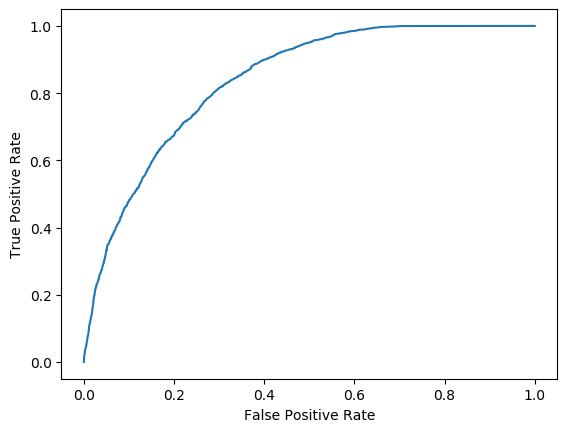

In [77]:
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Need an appropriate threshold to calculate the labels. I'll use Youden's J Statistic

You can read more [here](https://en.wikipedia.org/wiki/Youden%27s_J_statistic) and [here](https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python).

In [78]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]

,fpr,tpr,1-fpr,tf,thresholds
741,0.251886,0.747107,0.748114,-0.001006,0.350969


In [90]:
accuracy_score(y_actual, np.where(y_t_pred > 0.350969, 1, 0))

0.7477059594635475

In [91]:
f1_score(y_actual, np.where(y_t_pred > 0.350969, 1, 0))

0.6432848588537211

In [80]:
lightgbm.plot_importance(tuned_model)

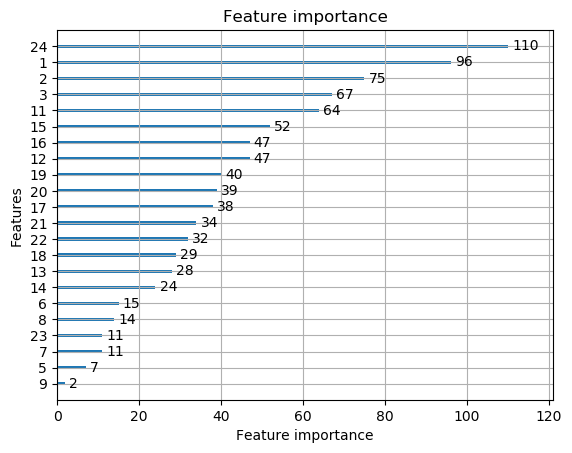

In [81]:
plt.show()

## Deploying LightGBM

In [82]:
inference_instance_type = "ml.m5.large"
time_stamp2 = datetime.strftime(datetime.now(), '%Y-%m-%d-%H-%M')
# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)



In [83]:
endpoint_name = name_from_base(f"lightgbm-{time_stamp2}")

# Use the estimator from the previous step to deploy to a SageMaker endpoint
predictor = best_estimator.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)

INFO:sagemaker:Creating model with name: sagemaker-jumpstart-2023-03-29-03-37-55-501
INFO:sagemaker:Creating endpoint-config with name lightgbm-2023-03-29-03-37-2023-03-29-03-37-55-500
INFO:sagemaker:Creating endpoint with name lightgbm-2023-03-29-03-37-2023-03-29-03-37-55-500


------!

In [84]:
newline, bold, unbold = "\n", "\033[1m", "\033[0m"

# read the data
test_data = pd.read_csv('/root/starbucks_offer_response_model/data/curated_data/test.csv', header = None)

test_data.columns = ["Target"] + [f"Feature_{i}" for i in range(1, test_data.shape[1])]

num_examples, num_columns = test_data.shape
print(
    f"{bold}The test dataset contains {num_examples} examples and {num_columns} columns.{unbold}\n"
)

# prepare the ground truth target and predicting features to send into the endpoint.
ground_truth_label, features = test_data.iloc[:, :1], test_data.iloc[:, 1:]

print(f"{bold}The first 5 observations of the data: {unbold} \n")
test_data.head(5)

The test dataset contains 9917 examples and 25 columns.

The first 5 observations of the data:  



,Target,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24
0,0,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0,0,0,1,0,0,1,0,0,1
1,0,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,1,0,0,0,1,0,0,2
2,0,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0,0,0,1,0,1,0,0,0,2
3,1,5.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1,0,0,0,0,1,0,0,0,2
4,1,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0,0,1,0,0,1,0,0,0,3


In [85]:
content_type = "text/csv"

def query_endpoint(encoded_tabular_data):
    # endpoint_name = endpoint_name
    client = boto3.client("runtime.sagemaker")
    response = client.invoke_endpoint(
        EndpointName=endpoint_name, ContentType=content_type, Body=encoded_tabular_data
    )
    return response


def parse_response(query_response):
    model_predictions = json.loads(query_response["Body"].read())
    predicted_probabilities = model_predictions["probabilities"]
    return np.array(predicted_probabilities)


In [86]:
import json

In [87]:
# split the test data into smaller size of batches to query the endpoint due to the large size of test data.
batch_size = 1500
predict_prob = []
for i in np.arange(0, num_examples, step=batch_size):
    query_response_batch = query_endpoint(
        features.iloc[i : (i + batch_size), :].to_csv(header=False, index=False).encode("utf-8")
    )
    predict_prob_batch = parse_response(query_response_batch)  # prediction probability per batch
    predict_prob.append(predict_prob_batch)


predict_prob = np.concatenate(predict_prob, axis=0)
predict_label = np.argmax(
    predict_prob, axis=1)

In [88]:
predict_prob

array([[0.56805643, 0.43194357],
       [0.99873616, 0.00126384],
       [0.29664571, 0.70335429],
       ...,
       [0.33009965, 0.66990035],
       [0.70140311, 0.29859689],
       [0.80513299, 0.19486701]])

The above is a successful implementation of a sagemaker endpoint.

In [89]:
# Delete the SageMaker endpoint and the attached resources
predictor.delete_model()
predictor.delete_endpoint()

INFO:sagemaker:Deleting model with name: sagemaker-jumpstart-2023-03-29-03-37-55-501
INFO:sagemaker:Deleting endpoint configuration with name: lightgbm-2023-03-29-03-37-2023-03-29-03-37-55-500
INFO:sagemaker:Deleting endpoint with name: lightgbm-2023-03-29-03-37-2023-03-29-03-37-55-500


# Logistic Regression

In [104]:
train_model_id, train_model_version, train_scope =  "sklearn-classification-linear", "*", "training"
training_instance_type = "ml.m5.xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)
# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


In [105]:
# Sample training data is available in this bucket
training_data_bucket = "starbucks-project-ttg"
training_data_prefix = "data"

training_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}/train.csv" 
validation_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}/val.csv" 
output_bucket = "starbucks-project-ttg"
output_prefix = "logistic_regression_training_results"
s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

In [106]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)
print(hyperparameters)

{'tol': '0.0001', 'penalty': 'l2', 'alpha': '0.0001', 'l1_ratio': '0.15'}


In [107]:
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base


training_job_name = name_from_base(f"logistic-regression-example-{train_model_id}-training")

# Create SageMaker Estimator instance
tabular_estimator_logit = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
)

# Launch a SageMaker Training job by passing s3 path of the training data
tabular_estimator_logit.fit({"training": training_dataset_s3_path}, logs=True, job_name=training_job_name)

INFO:sagemaker:Creating training-job with name: logistic-regression-example-sklearn-cla-2023-03-29-04-21-16-204


2023-03-29 04:21:17 Starting - Starting the training job...
2023-03-29 04:21:33 Starting - Preparing the instances for training...
2023-03-29 04:22:24 Downloading - Downloading input data...
2023-03-29 04:22:50 Training - Downloading the training image...
2023-03-29 04:23:00 Training - Training image download completed. Training in progress.2023-03-29 04:23:10,878 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2023-03-29 04:23:10,882 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-29 04:23:10,923 sagemaker_sklearn_container.training INFO     Invoking user training script.
2023-03-29 04:23:11,106 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/miniconda3/bin/python -m pip install -r requirements.txt
Processing ./lib/sagemaker_jumpstart_script_utilities/sagemaker_jumpstart_script_utilities-1.0.1-py2.py3-none-any.whl
[notice] A new release of pip is available: 23.0 -> 23.0

## Logistic Regression Out-of-Sample Testing

In [108]:
s3_output_location

's3://starbucks-project-ttg/logistic_regression_training_results/output'

In [109]:
! aws s3 cp s3://starbucks-project-ttg/logistic_regression_training_results/output/logistic-regression-example-sklearn-cla-2023-03-29-04-21-16-204/output/model.tar.gz /root/starbucks_offer_response_model/trained_models/logistic_regression

download: s3://starbucks-project-ttg/logistic_regression_training_results/output/logistic-regression-example-sklearn-cla-2023-03-29-04-21-16-204/output/model.tar.gz to ../trained_models/logistic_regression/model.tar.gz


In [110]:
tar_file_path = '/root/'+'starbucks_offer_response_model/trained_models/logistic_regression/model.tar.gz'

In [111]:
t = tarfile.open(tar_file_path)

In [112]:
t.extractall('/root/'+'starbucks_offer_response_model/trained_models/logistic_regression/')

In [113]:
model = joblib.load('/root/starbucks_offer_response_model/trained_models/logistic_regression/model.pickle.dat')

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [114]:
col_num = len(pd.read_csv('/root/starbucks_offer_response_model/data/curated_data/test.csv', header = None).columns)

In [115]:
col_list = ['offer_successful']
for i in range(col_num-1):
    col_list.append(f'feature_{i}')

In [116]:
test_df = pd.read_csv('/root/starbucks_offer_response_model/data/curated_data/test.csv', header = None)
test_df.columns = col_list

In [117]:
test_x_df = test_df.iloc[:,1:]

In [118]:
y_actual = test_df['offer_successful'].to_numpy()
y_actual

array([0, 0, 0, ..., 1, 0, 0])

In [131]:
y_pred = model.predict(test_x_df)

In [128]:
y_pred.transpose()

array([[6.70005226e-01, 9.99945521e-01, 4.93195148e-01, ...,
        3.01670257e-01, 7.28776147e-01, 8.41085625e-01],
       [3.29994774e-01, 5.44787257e-05, 5.06804852e-01, ...,
        6.98329743e-01, 2.71223853e-01, 1.58914375e-01]])

In [132]:
accuracy_score(y_actual, y_pred)

0.7594030452757891

In [137]:
roc_auc_score(y_actual,model.predict_proba(test_x_df).transpose()[1])

0.8218095959862435

In [138]:
f1_score(y_actual,y_pred)

0.5588017751479291